In [2]:
import numpy as np
import scipy
import os
import matplotlib.pyplot as plt
import sys
#
#
#CALLING CAMB SOURCES
#
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow


print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))


Using CAMB 1.3.6 installed at /Users/louis/Code/CAMBfork/camb


In [5]:

lmax=2000
pars = camb.CAMBparams()
cosmo1_dict={'Omegam':0.315143, 'OmegaL':0.684857, 'OmegaB':0.0491168,'h0':0.6726, 'nS':0.963, 'w0':-1., 'wa':0., 'sg80':0.83} # we create a "cosmo" dictionary with Planck DR2 values (fiducial model)
h0=cosmo1_dict['h0'] ; ombh2=cosmo1_dict['h0']**2*cosmo1_dict['OmegaB'] ; omch2=cosmo1_dict['h0']**2*(cosmo1_dict['Omegam']-cosmo1_dict['OmegaB'])
pars.set_cosmology(H0=h0*1e2, ombh2=ombh2, omch2=omch2)
print('>Omega_M, Omega_L=',(pars.ombh2+pars.omch2)/(pars.H0/1e2)**2,1.-(pars.ombh2+pars.omch2+pars.omnuh2)/(pars.H0/1e2)**2)
pars.InitPower.set_params(As=2e-9, ns=cosmo1_dict['nS'])
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = True
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both
#
biasP=1.66 ; biasR=3.8
zobs=np.array([0.3]) ; sgzar=np.array([0.01])
# this dictionary considers both ADF (source_type="counts") and ARF (source_type="arf") for the same shell
pars.SourceWindows=[GaussianSourceWindow(redshift=zobs[0],source_type='counts',bias=biasP,sigma=sgzar[0],dlog10Ndm=0.),\
	GaussianSourceWindow(redshift=zobs[0],source_type='arf',bias=biasP,sigma=sgzar[0],dlog10Ndm=0.)] 
#We only consider RSD term among relativistic corrections
pars.SourceTerms.counts_redshift=True ; pars.SourceTerms.counts_density=True
pars.SourceTerms.counts_lensing=False ; pars.SourceTerms.counts_radial=False ; pars.SourceTerms.use_21cm_mK=False
results = camb.get_results(pars)
cls1 = results.get_cmb_unlensed_scalar_array_dict(raw_cl=True)
#We drop the  RSD term and neglect all relativistic corrections (only density term)
pars.SourceTerms.counts_redshift=False ; pars.SourceTerms.counts_density=True
results = camb.get_results(pars)
cls2 = results.get_cmb_unlensed_scalar_array_dict(raw_cl=True)
ll0=np.arange(len(cls1['TxT'])) ; ll2=ll0[2:]
clADF=cls1['W1xW1'] ; clARF=cls1['W2xW2']
clADFr=cls2['W1xW1'] ; clARFr=cls2['W2xW2']
#



>Omega_M, Omega_L= 0.31514300000000006 0.683430935508899
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29999999999686283     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29999999999686283     


<Figure size 432x288 with 0 Axes>

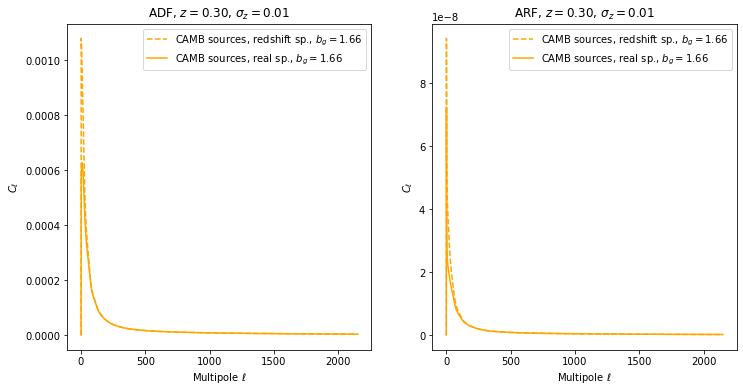

In [6]:
plt.clf()
fig,ax1=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
#
ax1[0].plot(ll0,clADF,color='orange',ls='dashed',label='CAMB sources, redshift sp., $b_g=$%.2f'%biasP)
ax1[0].plot(ll0,clADFr,color='orange',label='CAMB sources, real sp., $b_g=$%.2f'%biasP)
ax1[0].set_xlabel('Multipole $\ell$') ; ax1[0].set_ylabel('$C_{\ell}$') ; # ax1[0].set_xlim([1.,2*ns]) #; ax1[0].set_yscale('log')
ax1[0].set_title('ADF, $z=$%.2f, $\sigma_z=$%.2f'%(zobs[0],sgzar[0])) ; ax1[0].legend(loc='best',prop={'size': 10}) ; #ax1[0].set_ylim([0e0,8e-3])
#
sg=sgzar[0]
ax1[1].plot(ll0,clARF,color='orange',ls='dashed',label='CAMB sources, redshift sp., $b_g=$%.2f'%biasP)
ax1[1].plot(ll0,clARFr,color='orange',label='CAMB sources, real sp., $b_g=$%.2f'%biasP)
ax1[1].set_xlabel('Multipole $\ell$') ; ax1[0].set_ylabel('$C_{\ell}$')  ; ax1[1].set_ylabel('$C_{\ell}$') ; #ax1[1].set_xlim([1.,2.*ns]) #; ax1[1].set_yscale('log')
ax1[1].set_title('ARF, $z=$%.2f, $\sigma_z=$%.2f'%(zobs[0],sgzar[0])) ; ax1[1].legend(loc='best', prop={'size': 10}) ; # ax1[1].set_ylim([0e0,0.6e-6])
#
# plt.savefig('C_ell_tst.png',dpi=300)
